In [2]:
import gymnasium as gym
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from mpl_toolkits import mplot3d
import time 
import math
from tqdm import tqdm

In [8]:
'''
This cell will load the environment and select the render mode for the simulation, since it is not time consuming; 
the human node rendering is intended for the real-time simulation of the system (reported at the end of the monte-carlo section)
'''

env_name = 'CartPole-v1' 
env = gym.make(env_name, render_mode='rgb_array')   # for simulation
#env = gym.make(env_name, render_mode='human')      # for rendering

def intervals_split(start, finish, parts):
    '''
    function that, given an interval and the number of split to apply, 
    return a list of intervals equalli separated by the number of split given as input
    '''
    part_duration = (finish-start) / parts
    return [start+i * part_duration for i in range(parts+1)] 

n_split = [4,5,10,12]  # with 3 splits there are 5 intervals created, since two are that one that deal with +- infty

obs_list = []
observation, info = env.reset()
obs_list.append(observation)

#here we are observaing a sequence of 10000 actions took, without considering the number of episode
for _ in tqdm(range(1000)):
    action = env.action_space.sample()  # this is where you would insert your policy
    observation, reward, terminated, truncated, info = env.step(action)
    obs_list.append(observation)
    if terminated or truncated:
       observation, info = env.reset()
       
states = [[], [], [], []]
for k in range(len(obs_list)):
    states[0].append(obs_list[k][0])
    states[1].append(obs_list[k][1])
    states[2].append(obs_list[k][2])
    states[3].append(obs_list[k][3])
    
# took the extrema from the simulations 
extrema = []
intervals = []       
       
for k in range(len(states)):
    extrema.append([np.min(states[k]), np.max(states[k])])
    intervals.append(intervals_split(extrema[k][0], extrema[k][1], n_split[k]))

def state_projection(value, intervals):
    '''
    This function associate to each state observation a unique positive integer value, useful
    for constructing the Q_table
    '''
    #print(value)
    #print(len(value))
    discrete_state = []
    n_digits = []
    for k in range(len(value)):
        discrete_state.append(np.digitize(value[k], intervals[k])) # the k-th state description with the k-th intervals split
        n_digits.append(len(str(np.digitize(value[k], intervals[k]))))
    discrete_state = discrete_state[0]+discrete_state[1]*(n_split[0]+2)+discrete_state[2]*(n_split[0]+2)*(n_split[1]+2)+discrete_state[3]*(n_split[0]+2)*(n_split[1]+2)*(n_split[2]+2)
    
    return discrete_state


100%|██████████| 1000/1000 [00:00<00:00, 142969.77it/s]


In [9]:
'''
Let's resolve the same environment exploiting the SARSA algorithm, based on the TD(0) idea
'''

class SARSA_learning():
    
    def __init__(self, intervals, n_split, environment, epsilon = 0.9, alpha = 0.5, gamma = 0.9):  # in this case, we will use alpha as constant parameter for the update
                                                                                          # not alpha = 1/n as it is in the case of the MC implementation
        self.intervals = intervals
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.env = environment
        self.timestamps = []
        Q_height = 2 # since there are only two possible action 
        Q_width = (n_split[0]+2)*(n_split[1]+2)*(n_split[2]+2)*(n_split[3]+2)
        self.Q_table = np.zeros((2, Q_width))
        self.Counter_table = np.zeros_like(self.Q_table)
        
    def episode_init(self):
        state, info = self.env.reset()
        #print(state)
        state = state_projection(state, self.intervals)
        return state
    
    def action_choice(self, state):
        if((np.random.randint(0,100+1)/100) > self.epsilon):
            action = int(np.random.choice([0, 1], size=1, p=[.5, .5]))
        else:
            action = np.argmax(self.Q_table[:, state]) # take the max value associated to the Q_function 
        return action  
    
    def Q_update(self, state, action, new_state, new_action, reward):
        #print("state = {}  ; action = {}  ; new_state = {}  ; new_action = {}  ; reward = {}".format(state, action, new_state, new_action, reward))
        self.Q_table[action][state] += self.alpha*(reward - self.Q_table[action][state] + self.gamma*self.Q_table[new_action][new_state])
        return
    
    def play_an_episode(self):
        score = 0
        state = self.episode_init()
        action = self.action_choice(state)
        while(True):
            score +=1 
            new_state, reward, terminated, truncated, info = self.env.step(action)
            if terminated or truncated: 
                self.timestamps.append(score)
                break
            new_state = state_projection(new_state, self.intervals)
            new_action = self.action_choice(new_state)
            self.Q_update(state, action, new_state, new_action, reward)
            action = new_action 
            state = new_state
        
    def run(self, n_episodes=5000):
        for _ in tqdm(range(n_episodes)):
            self.play_an_episode()

100%|██████████| 5000/5000 [00:15<00:00, 325.76it/s]


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

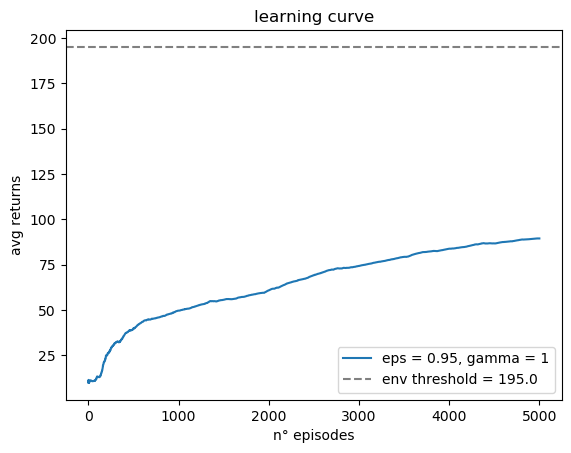

In [10]:
env = gym.make(env_name, render_mode='rgb_array')   # ] simulation 
SARSA_agent = SARSA_learning(intervals = intervals, n_split = n_split, environment = env)
SARSA_agent.run()
           
x = np.arange(len(SARSA_agent.timestamps))
accumul = 0
mobile_avg = []
counter = 0
for elem in SARSA_agent.timestamps: 
    counter += 1
    accumul = accumul + (1/counter)*(elem-accumul) 
    mobile_avg.append(accumul)
    
plt.plot(x,mobile_avg, label='eps = 0.95, gamma = 1')  # replace accordingly with the parameters used in the algorithm
plt.axhline(195.0, color='gray', label='env threshold = 195.0', linestyle='--')
plt.xlabel('n° episodes')
plt.ylabel('avg returns') 
plt.title('learning curve')
plt.legend()
plt.plot

In [ ]:
env = gym.make(env_name, render_mode='human')       # for rendering

# let's experience with the environment  
observation, info = env.reset()
curr_state = state_projection(observation, SARSA_agent.intervals)
for _ in range(10000):
   
   action = SARSA_agent.action_choice(curr_state) 
   new_state, reward, terminated, truncated, info = env.step(action)
   curr_state = state_projection(new_state, SARSA_agent.intervals)

   if terminated or truncated:
      observation, info = env.reset() 